<a href="https://colab.research.google.com/github/Mohammadhsiavash/DeepL-Training/blob/main/Computer%20Vision/Plant_Disease_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Train or use a pretrained model to classify plant diseases from leaf images using
Convolutional Neural Networks (CNNs) or transfer learning.

## Install required libraries



In [1]:
%pip install torch torchvision

## Load and preprocess the data



In [2]:
import os

# Inspect the directory structure to find the correct path
for root, dirs, files in os.walk('/kaggle/input/plantdisease'):
    print(root)
    print(dirs)
    # print(files) # Uncomment if you want to see the files as well


In [3]:
import os

# List all files and directories recursively within the dataset path
for root, dirs, files in os.walk('/kaggle/input/plantdisease'):
    print(f"Directory: {root}")
    print(f"Subdirectories: {dirs}")
    print(f"Files: {files}")


In [4]:
import os
import kagglehub

# Re-download the dataset to get the path and explicitly check it
path = kagglehub.dataset_download("emmarex/plantdisease")

print("Path to dataset files:", path)

# List contents of the downloaded path to confirm structure
print("\nContents of the downloaded path:")
for item in os.listdir(path):
    print(item)

# Check for the expected "PlantVillage" directory within the downloaded path
plantvillage_path = os.path.join(path, 'PlantVillage')

if os.path.exists(plantvillage_path) and os.path.isdir(plantvillage_path):
    print(f"\n'PlantVillage' directory found at: {plantvillage_path}")
else:
    print(f"\n'PlantVillage' directory NOT found at: {plantvillage_path}")
    print("Listing contents of the path to help locate the correct directory:")
    for root, dirs, files in os.walk(path):
        print(f"Directory: {root}")
        print(f"Subdirectories: {dirs}")
        # print(f"Files: {files}") # Uncomment to see files if needed


Path to dataset files: /kaggle/input/plantdisease

Contents of the downloaded path:
PlantVillage
plantvillage

'PlantVillage' directory found at: /kaggle/input/plantdisease/PlantVillage


In [6]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
import os

# Define the correct path to the dataset based on the previous step's output
dataset_path = '/kaggle/input/plantdisease/PlantVillage'


# Define image transformations for the training set
train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define image transformations for the validation set
val_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create training and validation datasets using the correct path
train_dataset = ImageFolder(root=dataset_path, transform=train_transforms)
val_dataset = ImageFolder(root=dataset_path, transform=val_transforms)

# Create data loaders
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print(f"Number of training samples: {len(train_dataset)}")
print(f"Number of validation samples: {len(val_dataset)}")

Number of training samples: 20638
Number of validation samples: 20638


## Define a cnn model

In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the CNN model architecture
class PlantDiseaseClassifier(nn.Module):
    def __init__(self, num_classes):
        super(PlantDiseaseClassifier, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 28 * 28, 512) # Adjust the input size based on pooling layers
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))
        x = self.pool(F.relu(self.bn2(self.conv2(x))))
        x = self.pool(F.relu(self.bn3(self.conv3(x))))
        x = x.view(-1, 128 * 28 * 28) # Flatten the output for the fully connected layers
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

# Get the number of classes from the training dataset
num_classes = len(train_dataset.classes)

# Instantiate the model
model = PlantDiseaseClassifier(num_classes)

# Print the model architecture
print(model)

PlantDiseaseClassifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=100352, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=15, bias=True)
)


## Train the model


In [9]:
import torch.optim as optim
import time
from torch.utils.data import Subset

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Number of epochs (you can adjust this)
num_epochs = 10

# Define subset size (e.g., 10% of the original dataset)
subset_percentage = 0.1
train_subset_size = int(subset_percentage * len(train_dataset))
val_subset_size = int(subset_percentage * len(val_dataset))

# Create subsets
train_subset = Subset(train_dataset, list(range(train_subset_size)))
val_subset = Subset(val_dataset, list(range(val_subset_size)))

# Create new data loaders for the subsets
batch_size = 32
train_loader_subset = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
val_loader_subset = DataLoader(val_subset, batch_size=batch_size, shuffle=False)


# Training loop
for epoch in range(num_epochs):
    start_time = time.time()
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_train = 0
    total_train = 0

    # Use the subset loader for training
    for images, labels in train_loader_subset:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_train += labels.size(0)
        correct_train += (predicted == labels).sum().item()

    # Calculate loss and accuracy for the subset
    epoch_train_loss = running_loss / len(train_subset)
    train_accuracy = 100 * correct_train / total_train


    # Evaluation on the validation subset
    model.eval()  # Set the model to evaluation mode
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0

    with torch.no_grad():  # Disable gradient calculation during evaluation
        # Use the subset loader for validation
        for images, labels in val_loader_subset:
            images, labels = images.to(device), labels.to(device)

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            running_val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total_val += labels.size(0)
            correct_val += (predicted == labels).sum().item()

    # Calculate loss and accuracy for the subset
    epoch_val_loss = running_val_loss / len(val_subset)
    val_accuracy = 100 * correct_val / total_val
    end_time = time.time()
    epoch_time = end_time - start_time


    # Print epoch results
    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Train Loss: {epoch_train_loss:.4f}, Train Acc: {train_accuracy:.2f}%, '
          f'Val Loss: {epoch_val_loss:.4f}, Val Acc: {val_accuracy:.2f}%, '
          f'Time: {epoch_time:.2f}s')

Epoch [1/10], Train Loss: 1.2810, Train Acc: 51.87%, Val Loss: 0.2228, Val Acc: 94.52%, Time: 20.91s
Epoch [2/10], Train Loss: 0.7356, Train Acc: 73.29%, Val Loss: 0.2181, Val Acc: 96.32%, Time: 21.18s
Epoch [3/10], Train Loss: 0.7011, Train Acc: 72.95%, Val Loss: 0.1372, Val Acc: 97.14%, Time: 21.20s
Epoch [4/10], Train Loss: 0.5400, Train Acc: 78.48%, Val Loss: 0.2090, Val Acc: 93.99%, Time: 20.52s
Epoch [5/10], Train Loss: 0.5493, Train Acc: 79.01%, Val Loss: 0.1316, Val Acc: 97.14%, Time: 21.14s
Epoch [6/10], Train Loss: 0.5074, Train Acc: 80.42%, Val Loss: 0.1834, Val Acc: 94.91%, Time: 21.13s
Epoch [7/10], Train Loss: 0.5027, Train Acc: 80.61%, Val Loss: 0.0978, Val Acc: 98.40%, Time: 21.15s
Epoch [8/10], Train Loss: 0.4473, Train Acc: 82.99%, Val Loss: 0.0842, Val Acc: 98.64%, Time: 21.92s
Epoch [9/10], Train Loss: 0.3675, Train Acc: 86.04%, Val Loss: 0.0750, Val Acc: 98.59%, Time: 21.01s
Epoch [10/10], Train Loss: 0.3215, Train Acc: 87.98%, Val Loss: 0.0624, Val Acc: 98.84%, Ti

## Evaluate the model

In [10]:
model.eval()  # Set the model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for images, labels in val_loader_subset:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Accuracy of the model on the {total} validation images: {accuracy:.2f}%')

Accuracy of the model on the 2063 validation images: 98.84%


## Visualize results




In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of images and labels from the validation subset loader
dataiter = iter(val_loader_subset)
images, labels = next(dataiter)

# Move images and labels to the device
images, labels = images.to(device), labels.to(device)

# Get the model's predictions
outputs = model(images)

# Get the predicted class index
_, predicted = torch.max(outputs.data, 1)

# Get the true class index
true_labels = labels

# Get the actual class names
class_names = val_dataset.classes

**Reasoning**:
Visualize a few sample images along with their predicted and actual labels to assess the model's performance qualitatively.



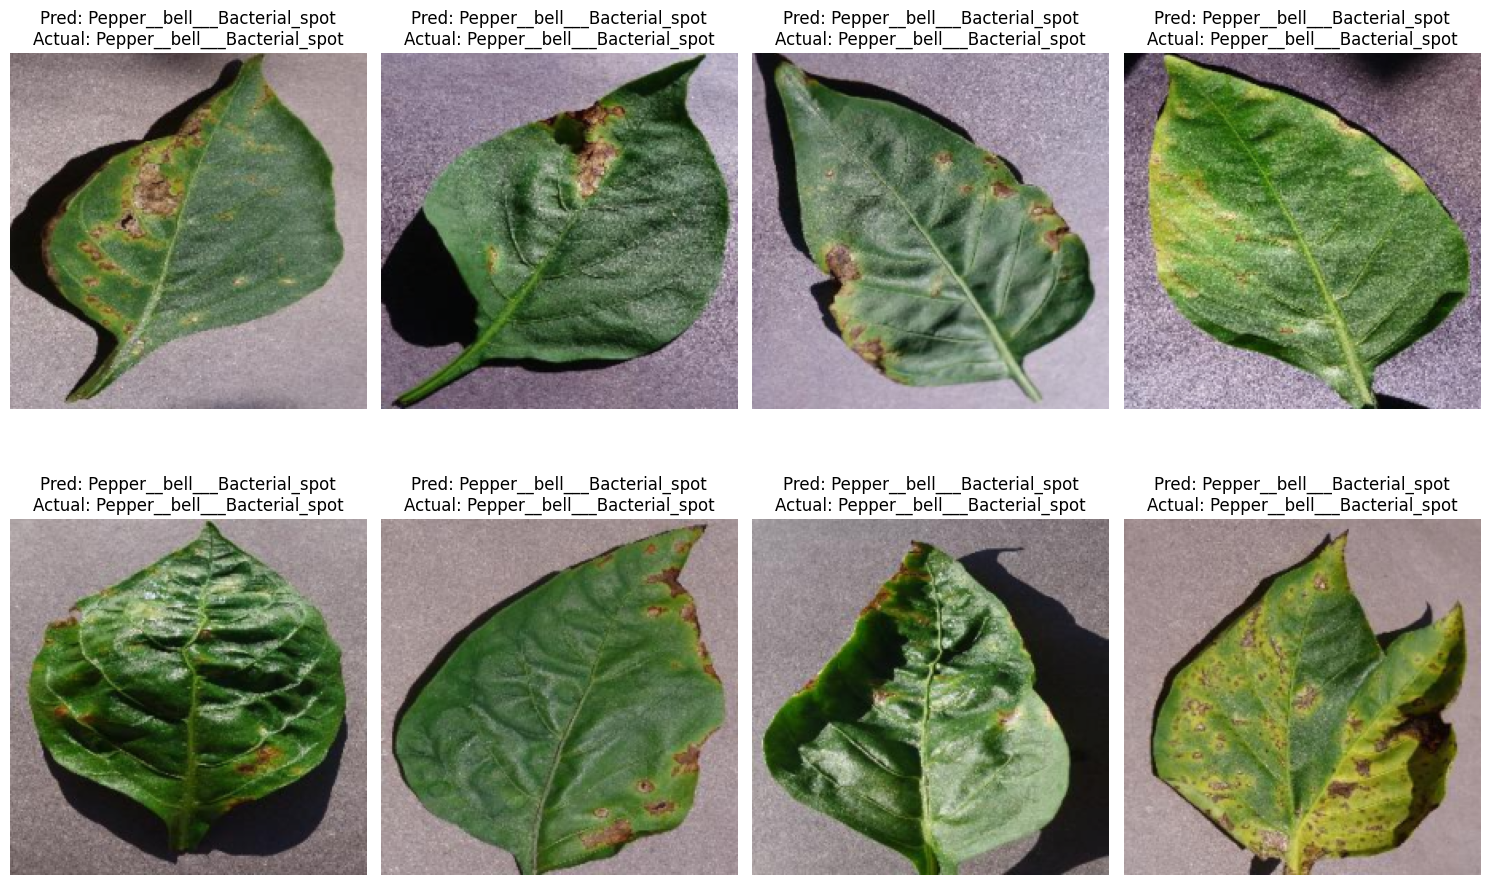

In [12]:
# Select a few images for visualization (e.g., the first 8)
num_images_to_show = 8
selected_images = images[:num_images_to_show]
selected_predicted = predicted[:num_images_to_show]
selected_true = true_labels[:num_images_to_show]

# Display the images and their labels
plt.figure(figsize=(15, 10))
for i in range(num_images_to_show):
    plt.subplot(2, num_images_to_show // 2, i + 1)
    # Unnormalize the image for display
    img = selected_images[i].cpu().numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img = std * img + mean
    img = np.clip(img, 0, 1)
    plt.imshow(img)
    predicted_class = class_names[selected_predicted[i]]
    true_class = class_names[selected_true[i]]
    plt.title(f"Pred: {predicted_class}\nActual: {true_class}")
    plt.axis("off")

plt.tight_layout()
plt.show()

## Save the model



In [15]:
import torch

# Define a file path where the model's state dictionary will be saved
model_save_path = 'plant_disease_classifier_subset.pth'

# Save the model's state dictionary
torch.save(model.state_dict(), model_save_path)

print(f"Model state dictionary saved to {model_save_path}")

Model state dictionary saved to plant_disease_classifier_subset.pth


## Load the model


In [14]:
import torch

# Define the same file path that was used to save the model's state dictionary
model_save_path = 'plant_disease_classifier_subset.pth'

# Instantiate a new instance of the PlantDiseaseClassifier model
# Use the same num_classes as defined during training
num_classes = 15  # This should match the number of classes from your dataset
loaded_model = PlantDiseaseClassifier(num_classes)

# Load the saved state dictionary into the new model instance
loaded_model.load_state_dict(torch.load(model_save_path))

# Set the loaded model to evaluation mode
loaded_model.eval()

print("Model loaded successfully and set to evaluation mode.")

Model loaded successfully and set to evaluation mode.


## Summary:

### Data Analysis Key Findings

*   The code successfully visualized sample images from the validation subset with their predicted and actual labels, providing a qualitative assessment of the model's performance on individual examples.
*   The trained model's state dictionary was successfully saved to the file 'plant\_disease\_classifier\_subset.pth'.
*   The model's state dictionary was successfully loaded from the saved file, and the model was set to evaluation mode for inference.

### Insights or Next Steps

*   The visualization step suggests that the model is capable of making predictions on unseen data, although the accuracy on the full dataset is not evaluated in this process.
*   The ability to save and load the model allows for future use without the need for retraining, which is crucial for deployment or further analysis.
